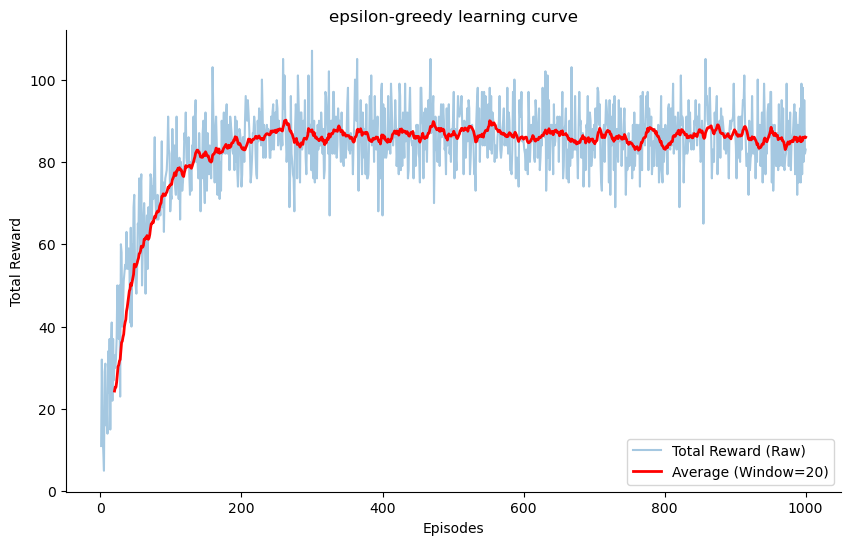

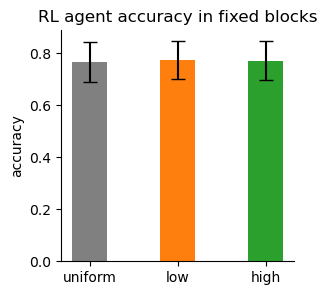

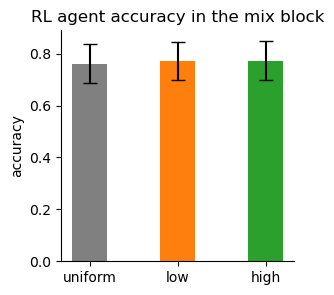

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Deck definitions
uniform_deck1 = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 
                 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 
                 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 
                 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 
                 9, 9, 9, 9, 9]
uniform_deck2 = uniform_deck1.copy()

low_deck1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 
             2, 2, 2, 2, 2, 2, 2, 2, 
             3, 3, 3, 3, 3, 3, 3, 
             4, 4, 4, 4, 4, 4, 
             5, 5, 5, 5, 5, 
             6, 6, 6, 6, 
             7, 7, 7, 
             8, 8, 
             9]
low_deck2 = low_deck1.copy()

high_deck1 = [9, 9, 9, 9, 9, 9, 9, 9, 9, 
              8, 8, 8, 8, 8, 8, 8, 8, 
              7, 7, 7, 7, 7, 7, 7, 
              6, 6, 6, 6, 6, 6, 
              5, 5, 5, 5, 5, 
              4, 4, 4, 4, 
              3, 3, 3, 
              2, 2, 
              1]
high_deck2 = high_deck1.copy()

# Create trials
def create_trials():
    def make_n_trials(deck1, deck2, deck_type, n=45):
        trials = []
        for _ in range(n):
            card1 = random.choice(deck1)
            card2 = random.choice(deck2)
            while card1 == card2:
                card2 = random.choice(deck2)
            trials.append((card1, card2, deck_type))
        return trials

    uniform_block = make_n_trials(uniform_deck1, uniform_deck2, "uniform", 45)
    low_block = make_n_trials(low_deck1, low_deck2, "low", 45)
    high_block = make_n_trials(high_deck1, high_deck2, "high", 45)
    
    uniform_final = make_n_trials(uniform_deck1, uniform_deck2, "uniform", 45)
    low_final = make_n_trials(low_deck1, low_deck2, "low", 45)
    high_final = make_n_trials(high_deck1, high_deck2, "high", 45)
    
    final_shuffled_block = uniform_final + low_final + high_final
    random.shuffle(final_shuffled_block)
    
    all_trials = uniform_block + low_block + high_block + final_shuffled_block
    return all_trials

# Q-learning parameters
q_table = {}
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.98
alpha = 0.01
gamma = 0.9
initial_reward = 10
num_episodes = 1000

reward_history = []
accuracy_history = {"uniform": [], "low": [], "high": [], "final_uniform": [], "final_low": [], "final_high": []}

# Helper functions
def get_state_key(card1, deck_type):
    return (card1, deck_type)

def epsilon_greedy_policy(state):
    if state not in q_table:
        q_table[state] = [0.0, 0.0]  
    if random.random() < epsilon:
        return random.choice([0, 1])  
    else:
        return np.argmax(q_table[state])  

# Training
for episode in range(num_episodes):
    trials = create_trials()
    total_reward = initial_reward
    correct_counts = {"uniform": 0, "low": 0, "high": 0, "final_uniform": 0, "final_low": 0, "final_high": 0}
    
    for idx, (card1, card2, deck_type) in enumerate(trials):
        state = get_state_key(card1, deck_type)
        action = epsilon_greedy_policy(state)
        
        if (action == 0 and card1 < card2) or (action == 1 and card1 > card2):
            r = 0.5
            if idx < 135:
                correct_counts[deck_type] += 1
            else:
                correct_counts[f"final_{deck_type}"] += 1
        else:
            r = -0.5
        
        if state not in q_table:
            q_table[state] = [0.0, 0.0]
        
        q_table[state][action] += alpha * (r + gamma * max(q_table[state]) - q_table[state][action])
        total_reward += r
    
    for key in accuracy_history:
        accuracy_history[key].append(correct_counts[key] / 45)
    reward_history.append(total_reward)
    
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay



plt.figure(figsize=(10, 6))
plt.plot(range(1, num_episodes + 1), reward_history, label='Total Reward (Raw)', alpha=0.4)
window_size = 20  
moving_avg = np.convolve(reward_history, np.ones(window_size) / window_size, mode='valid')
plt.plot(range(window_size, num_episodes + 1), moving_avg, label=f'Average (Window={window_size})', color='red', linewidth=2)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('epsilon-greedy learning curve')
plt.legend()

# Remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()





plt.figure(figsize=(3, 3))
labels = ["uniform", "low", "high"]
means = [np.mean(accuracy_history["uniform"]), np.mean(accuracy_history["low"]), np.mean(accuracy_history["high"])]
stds = [np.std(accuracy_history["uniform"]), np.std(accuracy_history["low"]), np.std(accuracy_history["high"])]
colors = ['#808080', '#ff7f0e', '#2ca02c']  # Custom colors

plt.bar(labels, means, yerr=stds, capsize=5, color=colors, width=0.4)  # Adjusted width
plt.ylabel("accuracy")
plt.title("RL agent accuracy in fixed blocks")

# Remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


# Bar Plot for Accuracy in Final 135 Trials
plt.figure(figsize=(3, 3))
means_final = [np.mean(accuracy_history["final_uniform"]), np.mean(accuracy_history["final_low"]), np.mean(accuracy_history["final_high"])]
stds_final = [np.std(accuracy_history["final_uniform"]), np.std(accuracy_history["final_low"]), np.std(accuracy_history["final_high"])]

plt.bar(labels, means_final, yerr=stds_final, capsize=5, color=colors, width=0.4)  # Adjusted width
plt.ylabel("accuracy")
plt.title("RL agent accuracy in the mix block")

# Remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()
